# Métodos sem malha
Este trabaho contará com a implementação de 03 métodos sem malha para estruturas elásticas e viscoelásticas em estruturas bidimensionais submetidas a estado plano de tensão ou deformação. Os métodos a serem implementados serão o da Colocação, Galerkin e Petrov-Galerkin. Todos utilizarão o Método dos Mínimos Quadrados Móveis para interpolação.

## Dependências
A seguir encontram-se as bibliotecas utilizadas no presente trabalho.

In [9]:
%matplotlib notebook

import matplotlib
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
from numpy import linalg as la
import matplotlib.pyplot as plt
import pprint as pp

## Dados
Abaixo encontram-se os dados utilizados nos problemas abaixo.
 
  - interpolação: $z = 3+2x+5x^2+4xy$

In [2]:
# Dados da Interpolação:
interpol_data = [
    [-1,-1,10],
    [1,-1,6],
    [-1,0,6],
    [0,0,3],
    [1,0,10],
    [-1,1,2],
    [0,1,3],
    [1,1,14]
]
interpol_base = ["1","x","x**2","y","y**2","x*y"]; #Base quadrática
#interpol_base = ["1","x","y"]; #Babse Linear
#interpol_base = ["1","x","y","x**2,"x*y","y**2","x**3","(x**2)*y","x*(y**2)","y**3"];

In [9]:
# Dados Método Sem Malha
pde_base = ["1","x","x**2","y","y**2","x*y"]; #Base quadrática
pde_base_x = ["0","1","2*x","0","0","y"] #Derivada primeira da base em relação a x
pde_base_xx = ["0","0","2","0","0","0"] #Derivada segunda da base em relação a x
pde_base_y = ["0","0","0","1","2*y","x"] #Derivada primeira da base em relação a y
pde_base_yy = ["0","0","0","0","2","0"] #Derivada segunda da base em relação a y

#pde_base = ["1","x","y"]; #Base Linear
#pde_base = ["1","x","y","x**2,"x*y","y**2","x**3","(x**2)*y","x*(y**2)","y**3"];

k = 3
sizeix = 0 #Tamanho inicial do domínio em y
sizeiy = 0 #Tamanho inicial do domínio em x
sizex = 1 #tamanho do domínio em x
sizey = 1 #tamanho do domínio em y
pde_domain_count = (k-1)**2 #número de pontos no domínio
pde_contour_count = k*4 #número de pontos no contorno

count_left = [[sizeiy,sizey*y/k] for y in range(1,k+1)] #Pontos no contorno esquerdo
count_right = [[sizex,sizey*y/k] for y in range(1,k+1)] #Pontos no contorno direito
count_bottom = [[sizex*x/k,sizeix] for x in range(1,k+1)] #Pontos no contorno abaixo
count_top = [[sizex*x/k,sizey] for x in range(1,k+1)] #Pontos no contorno acima

domain = [[sizex*x/k,sizey*y/k] for x in range(1,k) for y in range(1,k)]

pde_data = domain + count_left + count_right + count_bottom + count_top


In [10]:
#Dados sobre a minha PDE e condições de contorno

pde_differential_x = { #Sobre minha equação diferencial
    'order': 2, #Ordem da minha PDE
    'var': 'x', #Variável utilizada
    'base1': pde_base_x,
    'base2': pde_base_xx
}

pde_differential_y = { #Sobre minha equação diferencial
    'order': 2, #Ordem da minha PDE
    'var': 'y', #Variável utilizada
    'base1': pde_base_y,
    'base2': pde_base_yy
}

#Objetos que representam as condições de contorno 

pde_contour_conditions = {
    'top': {
        'kind': 'dirichlet', #Caracteristicas do objeto top
        'value': 100
    },
    'bottom': {
        'kind': 'dirichlet',
        'value': 10
    },
    'left': {
        'kind': 'neumann',
        'order': 1,
        'var': 'x',
        'base1': pde_base_x,
        'base2': pde_base_xx,
        'value': 0
    },
    'right': {
        'kind': 'neumann',
        'order': 1,
        'var': 'x',
        'base1': pde_base_x,
        'base2': pde_base_xx,
        'value': 0
    }
}

#A função que define quando utilizar cada objeto
def pde_countor_class(p): #p = parametro para saber a cond
    if p[0] == sizeix:
        return 'left'
    elif p[0] == sizex:
        return 'right'
    elif p[1] == sizeiy:
        return 'bottom'
    elif p[1] == sizey:
        return 'top'
    else:
        return None
    
#Definir minha função se for contorno:

def pde_countor_func(p):
    clazz = pde_countor_class(p)
    cond = pde_countor_conditions[clazz]
    return cond['value']

def pde_domain_func(p):
    return 0 #retorna a função que é dada no domínio 

def pde_func(p):
    clazz = pde_countor_class(p)
    if clazz == None:
        return pde_domain_func(p)
    else:
        return pde_countor_func(p)


## Definição Função Peso

Criar a função gaussiana com raio e Função Spline, verificando qual se comporta melhor na modelagem.

$\textbf{Função Gaussiana com raio:}$

$
w(\vec d) = 
\begin{cases}
\dfrac{{e^{-({\frac{||\vec d||}c})^2}} - {e^{-({\frac r c})^2}}}{1-{e^{-({\frac{r}c})^2}}}, \ d < r
\\\\
0, \ d > r
\end{cases}
$

$\textbf{Função Spline:}$

$
w(\vec d) = 
\begin{cases}
\ {1- 6{({\frac{||\vec d||}r})^2} + 8{({\frac{||\vec d||}r})^3} - 3{({\frac{||\vec d||}r})^4}}, \ d < r
\\\\
0, \ d > r
\end{cases}
$

$\textbf{Obs:}$ 
- dist: $\textbf{x} $ - $\textbf{x$_{j}$} $ = $\vec d $
    
- r: raio limite do subdominio (suporte)
    
    
 

<IPython.core.display.Javascript object>


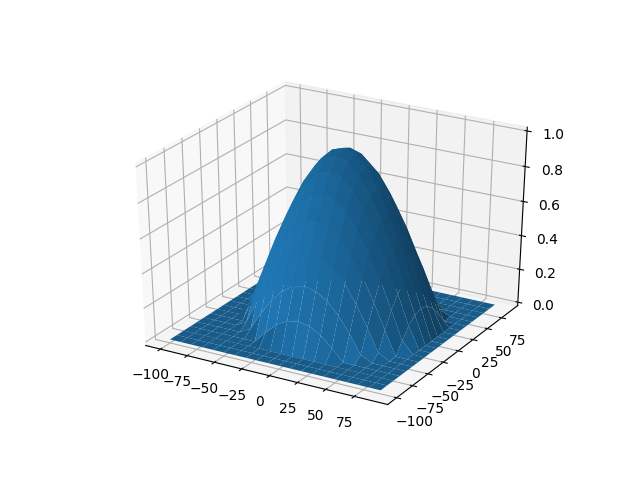

In [11]:
def gaussian_with_radius (dist,r):
    c = 100
    exp1 = np.exp(-(la.norm(dist)/c)**2) #Exponencial 2
    exp2 = np.exp(-(r/c)**2) #Exponencial 1
    weight = (exp1 - exp2)/(1 - exp2)
    
    return weight if (la.norm(dist)<=r) else 0 


def spline (dist,r):
    div = la.norm(dist)/r
    weight = 1 - 6*(div**2)+8*(div**3)-3*((div**4))
    
    return weight if (la.norm(dist) <=r) else 0

fig = plt.figure("Função Peso: Gaussiana com raio")
xs = np.arange(-100,100,10)
ys = np.arange(-100,100,10)
X, Y = np.meshgrid(xs, ys)

zs = np.array([ gaussian_with_radius([x,y],80) for x,y in zip(np.ravel(X), np.ravel(Y))])
Z=zs.reshape(X.shape)

mesh_plot = fig.add_subplot(111, projection='3d')
mesh_plot.plot_surface(X,Y,Z)


## Matriz Peso $(W)$

In [12]:
def W (data,point,r): #data =  número de ptos, point = ponto analisado, r = raio mínimo
    W = []
    for index,row in enumerate(data):
        d2d = row[0:2] # (x,y)
        leftZeroes = np.zeros([1,index]) # 0 0 0 ... 0 } index vezes
        rightZeroes = np.zeros([1,len(data) - index - 1])
        weight = gaussian_with_radius(np.subtract(d2d,point),r)
        newRow = np.concatenate([leftZeroes,[[weight]],rightZeroes],axis=1)[0]
        W.append(newRow)
    return W

## Matriz de Base $(P)$

In [13]:
def create_base(base,data):
    P = []
    for dat in data:
        row = []
        for b in base:
            [x,y] = dat[0:2]
            row.append(eval(b))
        P.append(row)
    return P

## Raio mínimo $(r)$
    Parâmetros:
 - `data`: conjunto de dados
 - `points`: pontos de referência
 - `m`: quantidade de pontos no suporte

In [14]:
def get_radius(data,point,m):
    distances = []
    for dat in data:
        dif = np.subtract(point,dat[0:2])
        dist = la.norm(dif)
        distances.append(dist)
    distances = sorted(distances);
    return distances[m+1]

## Coeficientes $\varphi_k(x)$
Coeficientes utilizados na interpolação linear
$$
\begin{aligned}
B(x) &= P^TW(x)\\
A(x) &= B(x)P = P^TW(x)P\\
\varphi^T(x)&=p^TA^{-1}(x)B(x)
\end{aligned}
$$

In [15]:
def coefficients(data,point,base):
    m = len(pde_base)
    r = get_radius(data,point,m)
    P = create_base(base,data)
    Pt = np.transpose(P)
    pt = create_base(base,[point])
   # ide = ideal(data,base,point,r)
    
    while True:
        B = Pt@W(data,point,r)
        A = B@P
        det = la.det(A)
        if(abs(det) < 1e-3):
            r*=1.1;
           # print(ide(data,base,point,r))
            continue
        else:
            return pt@la.inv(A)@B
    
        
        

## Função de Interpolação $(ũ)$

In [16]:
def interpol(data,base,point):
    c = coefficients(data,point,base)
    u = np.array([z for x,y,z in data])
    
    return np.matmul(c,u)

## Teste de Interpolação

<IPython.core.display.Javascript object>


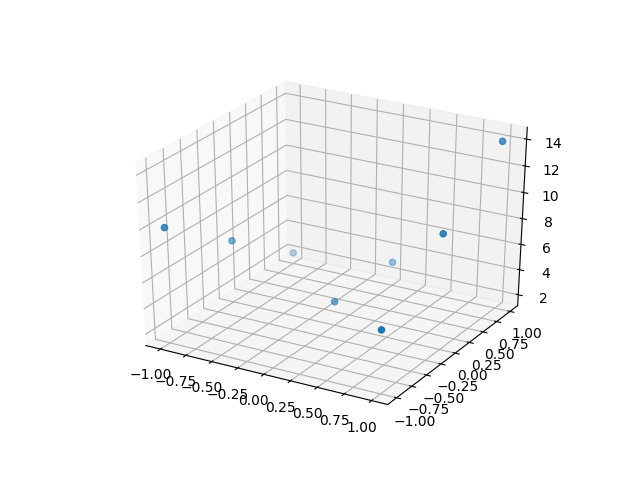

<IPython.core.display.Javascript object>


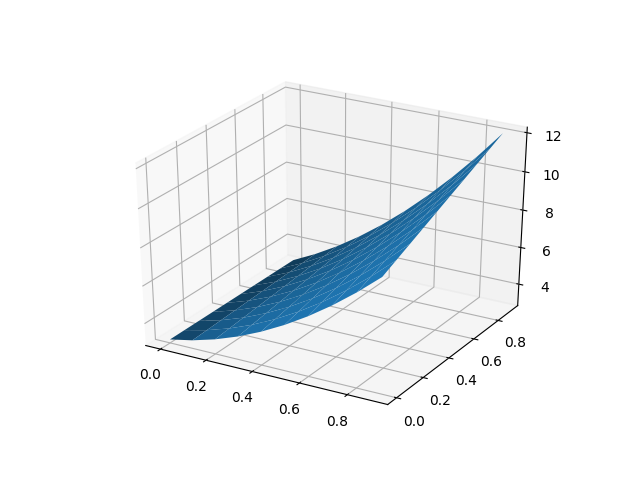

In [17]:
xs = [x for x,y,z in interpol_data]
ys = [y for x,y,z in interpol_data]
zs = [z for x,y,z in interpol_data]

fig = plt.figure("interpol - dados")

data_plot = fig.add_subplot(111, projection='3d')
data_plot.scatter(xs,ys,zs)

fig = plt.figure("interpol -aproximação")
xs = np.arange(0,1,0.1)
ys = np.arange(0,1,0.1)
X, Y = np.meshgrid(xs, ys)

zs = np.array([interpol(interpol_data,interpol_base,[x,y]) for x,y in zip(np.ravel(X), np.ravel(Y))])
Z=zs.reshape(X.shape)

mesh_plot = fig.add_subplot(111, projection='3d')
mesh_plot.plot_surface(X,Y,Z)
